In [1]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import feature_selection, linear_model, metrics
from sklearn import model_selection, multioutput, pipeline, preprocessing

# Multioutput Classification

# MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

In [2]:
# might be different if using Colab or Kaggle
PROJECT_ROOT_DIR = pathlib.Path(".")

DATA_DIR = PROJECT_ROOT_DIR / "data" / "mnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT_DIR / "results" / "mnist"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Download and extract the data (if using Colab or Kaggle!)

In [3]:
URL = "https://github.com/davidrpugh/machine-learning-for-tabular-data/blob/main/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


In [4]:
%%bash
ls -lh ./data/mnist

total 21M
-rw-r--r-- 1 root root 21M Jan 27 02:47 mnist.parquet


## Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [5]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

## Explore the data

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [7]:
features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
features.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


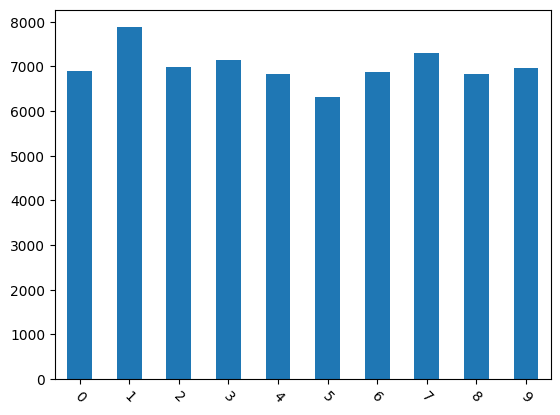

In [10]:
_ = (target.value_counts()
           .sort_index()
           .plot(kind="bar"))
_ = plt.xticks(rotation=-45)

## Train-Test Split

In [11]:
model_selection.train_test_split?

In [13]:
TEST_SIZE = 1e-1

# split the dataset into training and testing data
_random_state = np.random.RandomState(42)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    stratify=target,
    random_state=_random_state
)

In [14]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 29990 to 43298
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [15]:
train_features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
29990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_target.head()

29990    2
67438    6
22891    7
55259    0
18172    5
Name: label, dtype: uint8

In [17]:
train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.0,63000.0,63000.0,63000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.199524,0.104095,0.051111,0.017778,0.010524,0.000921,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.005698,4.401675,2.929272,1.637365,1.318174,0.231078,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,58.000000,0.0,0.0,0.0,0.0


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [18]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

## Multioutput Classification

In [20]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(train_features), 784))
noisy_train_features = train_features + noise

noise = np.random.randint(0, 100, (len(test_features), 784))
noisy_test_features = test_features + noise


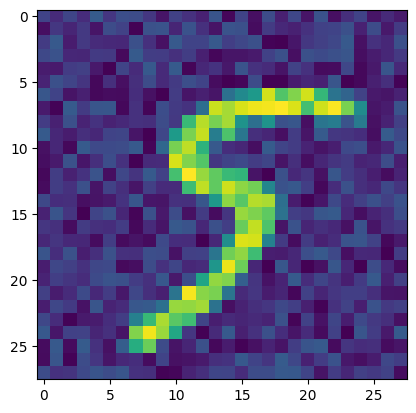

In [34]:
k = 4
noisy_digit = (
    noisy_train_features.iloc[[k]]
                        .to_numpy()
                        .reshape((28, 28))
)
_ = plt.imshow(noisy_digit)

In [21]:
from sklearn import neighbors

estimator = neighbors.KNeighborsClassifier()
_ = estimator.fit(noisy_train_features, train_features)

In [35]:
clean_digit = (
    estimator.predict(noisy_train_features.iloc[[k]])
             .reshape((28, 28))
)

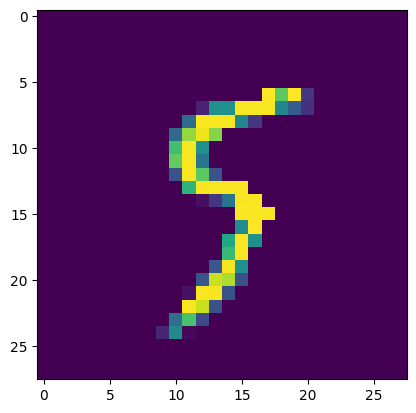

In [36]:
_ = plt.imshow(clean_digit)